In [1]:
import matplotlib.pyplot as plt

import pandas as pd
pd.options.mode.chained_assignment = None  # default='warn'

import numpy as np
import math

import random
random.seed(42)

# KOOS computation

## Data Loading

In [2]:
questionnaires = pd.read_csv('data/questionnaires.csv')
questionnaires = questionnaires.dropna(how="all")
questionnaires.reset_index(inplace=True)

print(questionnaires.shape)
questionnaires.head(3)

(300, 45)


,index,ID,knee,S1,S2,S3,S4,S5,S6,S7,...,A17,SP1,SP2,SP3,SP4,SP5,Q1,Q2,Q3,Q4
0,0,1.0,left,Never,Sometimes,Never,Always,Always,None,None,...,Mild,Extreme,Extreme,Extreme,Extreme,Extreme,Constantly,Not at all,Totally,Extreme
1,1,NaN,NaN,Never,Rarely,Rarely,Sometimes,Sometimes,None,None,...,Mild,Extreme,Extreme,Extreme,Extreme,Extreme,Constantly,Not at all,Totally,Extreme
2,2,NaN,NaN,Sometimes,Sometimes,Sometimes,Sometimes,Sometimes,Moderate,Moderate,...,Mild,Extreme,Extreme,Extreme,Sever,Extreme,Constantly,Moderately,Extremely,Sever


In [3]:
questionnaires.ID.fillna(method='ffill', inplace=True)
questionnaires.knee.fillna(method='ffill', inplace=True)
questionnaires.tail()

,index,ID,knee,S1,S2,S3,S4,S5,S6,S7,...,A17,SP1,SP2,SP3,SP4,SP5,Q1,Q2,Q3,Q4
295,369,74.0,Right,Never,Often,Sometimes,Always,Sometimes,Moderate,Moderate,...,Mild,Sever,Sever,Moderate,Mild,Moderate,Weekly,Mildly,Mildly,Mild
296,371,75.0,Left,Never,Often,Never,Always,Often,Moderate,None,...,Moderate,Sever,Sever,Sever,Mild,Sever,Constantly,Severly,Severly,Extreme
297,372,75.0,Left,Never,Sometimes,Never,Always,Often,Mild,None,...,Mild,Sever,Moderate,Moderate,Mild,Sever,Daily,Severly,Severly,Sever
298,373,75.0,Left,Never,Always,Never,Always,Often,None,None,...,Moderate,Sever,Sever,Sever,Moderate,Sever,Weekly,Not at all,Moderately,Moderate
299,374,75.0,Left,Never,Often,Rarely,Always,Always,Moderate,None,...,None,Sever,None,Moderate,Moderate,Moderate,Weekly,Moderately,Moderately,Moderate


## Main functions

In [4]:
## data cleaning            
def data_cleaning(data, cols):
    df = data.copy()
    for cname in cols:
        if cname != 'ID':
            df[cname] = df[cname].str.strip()
            df[cname] = df[cname].str.lower()
        
        df[cname].replace('no standing', np.nan, inplace=True)  
        df[cname].replace(['moderately', 'moderatly'], 
                          ['moderate', 'moderate'], inplace=True)  
        df[cname].replace('miod', 'mild', inplace=True)
        df[cname].replace('no', 'none', inplace=True)
        df[cname].replace(['mid', 'mildly', 'midly', 'mildy'], 
                          ['mild', 'mild', 'mild', 'mild'], inplace=True)
        df[cname].replace('constantly', 'always', inplace=True)
        df[cname].replace('not at all', 'never', inplace=True)
        df[cname].replace('totally', 'always', inplace=True)
        df[cname].replace('extremely', 'extreme', inplace=True)
        df[cname].replace(['severly', 'sever'], 'severe', inplace=True)
    return df

## ordinary encoding
def ordinary_encoding(data, cols):
    df = data.copy()
    for cname in cols:
        df[cname].replace(['never', 'none', 'rarely', 'mild', 'slight pain', 'sometimes', 'sometime', 'moderate', 'often', 'sever', 'severe', 'always', 'extreme', 'exterem'],
                          [0,0,  1,1,1,  2,2,2,  3,3,3,   4,4,4], inplace=True)
        
        df[cname].replace(['never', 'monthly', 'weekly', 'daily', 'always'],
                          [0,        1,         2,        3,       4], inplace=True)
    return df

def ordinary_encoding_Symptom_S4_S5(data, cols):
    df = data.copy()
    for cname in cols:
        df[cname].replace(['never', 'none', 'rarely', 'mild', 'sometimes', 'sometime', 'moderate', 'often', 'sever', 'severe', 'always', 'extreme'],
                          [4,4,  3,3, 2,2,2,  1,1,1,   0,0], inplace=True)
    return df

## mean KOOS 
def mean_KOOS(x):
    som = 0
    n   = 0
    score = np.nan
    
    for val in x:
        if not math.isnan(val):
            som += val
            n   += 1
            
    score = 100 - ((som/n)*(100/4))
    
    return round(score, 2)

## count the missing values
def missing_val(x):
    som = 0
    for val in x:
        if not math.isnan(val):
            som += 1
    return som

## check unique values
def unique_val(df, cols):
    for cname in cols:
        print(df[cname].unique()) 

## Recover rate function 
this function compute the recover rate between two consecutives questionnaires 

In [5]:
def sub_koos_recover_rate(df, cname):
    """
        compute the recover rate between the first and the last KOOS
    """
    L = []
    for i in range(4, len(df)+1, 4):
        tmp = df.iloc[i-1][cname] - df.iloc[i-4][cname]
        L.append(round(tmp,3))
        
    return L

In [6]:
def recover_rate(df):
    """
        compute the recover rate between two consecutive questionaire of the same patient
    """
    L = [np.nan]
    for i in range(1, len(df)-1):
        if df.iloc[i-1].ID == df.iloc[i].ID:
            tmp = df.iloc[i].KOOS - df.iloc[i-1].KOOS
            L.append(round(tmp,3))
        else:
            L.append(np.nan)
            
    tmp = df.iloc[i+1].KOOS - df.iloc[i].KOOS
    L.append(tmp)
    
    return L

In [7]:
def first_KOOS(df):
    """
        extract the first KOOS per patient
    """
    L1 = []  #first
    for i in range(len(df)-1):
        if i==0:
            tmp = df.iloc[i].KOOS 
            L1.append(round(tmp,2))
            L1.append(np.nan)
            continue
            
        elif df.iloc[i].ID != df.iloc[i+1].ID:
            tmp = df.iloc[i+1].KOOS 
            L1.append(round(tmp,2))
            
        else:
            L1.append(np.nan)
    return L1

############
def last_KOOS(df):
    """
        extract the last KOOS per patient
    """
    L2 = []  # first
    for i in range(len(df)-1):        
        if df.iloc[i].ID != df.iloc[i+1].ID:
            tmp = df.iloc[i].KOOS 
            L2.append(round(tmp,2))
            
        else:
            L2.append(np.nan)
            
    L2.append(round(df.iloc[i].KOOS, 2))
    return L2

## Recover ++ or --

In [8]:
def grade(rows):
    if rows['Recover_rate'] > 0:
        return "++"
    else:
        return "--"

## KOOS class

In [9]:
class KOOS:
    def __init__(self, df, name, cols):
        self.name = name
        self.data = data_cleaning(df[cols], cols)
        
        # data cleaning
        if name=='Symptom':
            self.data_encode = ordinary_encoding(self.data, ['S1', 'S2', 'S3', 'S6', 'S7'])
            self.data_encode = ordinary_encoding_Symptom_S4_S5(self.data_encode, ['S4', 'S5'])
            print(self.data_encode.columns)
    
        else:
            print('else')
            self.data_encode = ordinary_encoding(self.data[cols[1:]], cols[1:])
            
        ## KOOS score    
        df = self.data_encode.copy()
        df[name+'_'+'KOOS'] = df[cols[1:]].apply(mean_KOOS, axis=1)
        self.koos = df
            
        ## non missing value
        data_missing_val = self.koos.copy()
        data_missing_val['Non_missing_val'] = data_missing_val[cols[1:]].apply(missing_val, axis=1)
        self.data_missing_val = data_missing_val

## KOOS Symptoms subscale
Number of non missing items needed per questionnaire to compute the Symptom KOOS according to the _2012 rule for missing value_ = $4$ 

In [10]:
label = ['S'+str(i) for i in range(1,8)]
label.insert(0, 'ID')
print(label)

name = 'Symptom'
symptoms = KOOS(questionnaires, name, label)
#print(symptoms.data.head())
#unique_val(symptoms.data, symptoms.cols[1:])
#print(symptoms.data_encode.head()) 
#symptoms.koos.head()
#symptoms.data_encode.dtypes
#symptoms.data_encode.iloc[:,1:]

symptoms.data_missing_val.Non_missing_val.unique()

['ID', 'S1', 'S2', 'S3', 'S4', 'S5', 'S6', 'S7']
Index(['ID', 'S1', 'S2', 'S3', 'S4', 'S5', 'S6', 'S7'], dtype='object')


array([7])

## KOOS Pain subscale
Number of non missing items needed per questionnaire to compute the Pain KOOS according to the _2012 rule for missing value_ = $5$ 

In [11]:
label = ['P'+str(i) for i in range(1,10)]
label.insert(0, 'ID')
print(label)

name = 'Pain'
pain = KOOS(questionnaires, name, label)
#unique_val(pain.data, label[1:])
#pain.data.P2.value_counts()
#pain.data[pain.data.P2.pain.data_missing_val.head()isna()]

pain.data_missing_val.Non_missing_val.unique()

['ID', 'P1', 'P2', 'P3', 'P4', 'P5', 'P6', 'P7', 'P8', 'P9']
else


array([9, 7, 8])

## KOOS Function, Daily Living (ADL) subscale
Number of non missing items needed per questionnaire to compute the ADL KOOS according to the _2012 rule for missing value_ = $9$

In [12]:
label = ['A'+str(i) for i in range(1,18)]
label.insert(0, 'ID')
print(label)

name = 'ADL'
ADL = KOOS(questionnaires, name, label)
#ADL.data_encode

ADL.data_missing_val.Non_missing_val.unique()

['ID', 'A1', 'A2', 'A3', 'A4', 'A5', 'A6', 'A7', 'A8', 'A9', 'A10', 'A11', 'A12', 'A13', 'A14', 'A15', 'A16', 'A17']
else


array([17, 16])

## KOOS Function, Sport and Recreational activities
Number of non missing items needed according to the _2012 rule for missing items_ to compute the KOOS Symtoms = $3$

In [13]:
label = ['SP'+str(i) for i in range(1,6)]
label.insert(0, 'ID')
print(label)

name = 'Sport_Rec'
Sport_Rec = KOOS(questionnaires, name, label)

Sport_Rec.data_missing_val.Non_missing_val.unique()

['ID', 'SP1', 'SP2', 'SP3', 'SP4', 'SP5']
else


array([5, 4])

## KOOS Quality of life
Number of items needed according to the _2012 rule for missing items_ = $2$

In [14]:
label = ['Q'+str(i) for i in range(1,5)]
label.insert(0, 'ID')
print(label)

name = 'QOL'
QOL = KOOS(questionnaires, name, label)

QOL.data_missing_val.Non_missing_val.unique()

['ID', 'Q1', 'Q2', 'Q3', 'Q4']
else


array([4, 3])

## Final KOOS 

In [15]:
output = pd.DataFrame({'ID': questionnaires.ID, 
                       'Symptom': symptoms.koos['Symptom_KOOS'],
                       'Pain': pain.koos['Pain_KOOS'],
                       'ADL' : ADL.koos['ADL_KOOS'],
                       'Sport_Rec': Sport_Rec.koos['Sport_Rec_KOOS'],
                       'QOL': QOL.koos['QOL_KOOS']                       
                      })

output.head()

,ID,Symptom,Pain,ADL,Sport_Rec,QOL
0,1.0,92.86,44.44,57.35,0.0,25.00
1,1.0,78.57,50.00,63.24,0.0,25.00
2,1.0,50.00,52.78,64.71,5.0,18.75
3,1.0,57.14,55.56,66.18,5.0,18.75
4,2.0,42.86,25.00,13.24,0.0,12.50


## Most improved subscale

In [16]:
def subscale_RR(data, cnames):
    dic = {}
    for cname in cnames:
        dic[cname] = sub_koos_recover_rate(data, cname)
    return dic
    
sub_RR = subscale_RR(output, output.columns[1:])
Subscale_RR = pd.DataFrame.from_dict(sub_RR)
Subscale_RR.head()

,Symptom,Pain,ADL,Sport_Rec,QOL
0,-35.72,11.12,8.83,5.0,-6.25
1,0.00,33.33,22.05,25.0,25.00
2,10.71,27.78,20.59,20.0,6.25
3,14.28,0.00,13.24,10.0,-31.25
4,-7.15,8.33,8.83,45.0,31.25


<AxesSubplot:>

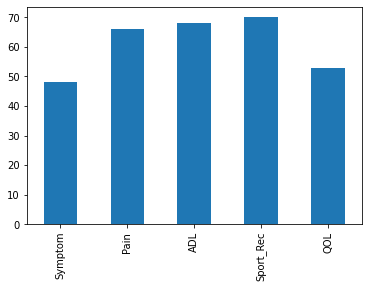

In [17]:
positive_count = Subscale_RR.where(Subscale_RR.gt(0)).count()
#print(positive_count)

positive_count.plot(kind='bar',x='subscale',y='recover patients')

## Final KOOS for the 5 first subscales

In [18]:
output['KOOS'] = output.iloc[:, 1:6].mean(axis=1)

output.head()

,ID,Symptom,Pain,ADL,Sport_Rec,QOL,KOOS
0,1.0,92.86,44.44,57.35,0.0,25.00,43.930
1,1.0,78.57,50.00,63.24,0.0,25.00,43.362
2,1.0,50.00,52.78,64.71,5.0,18.75,38.248
3,1.0,57.14,55.56,66.18,5.0,18.75,40.526
4,2.0,42.86,25.00,13.24,0.0,12.50,18.720


## Summary

In [19]:
first  = first_KOOS(output)
last   = last_KOOS(output)

output['first_KOOS']   = first
output['last_KOOS']    = last

output['Recover_rate'] = recover_rate(output)
output['Recover_rate'] = output['Recover_rate'].fillna(0.0)

output.head(10)

,ID,Symptom,Pain,ADL,Sport_Rec,QOL,KOOS,first_KOOS,last_KOOS,Recover_rate
0,1.0,92.86,44.44,57.35,0.0,25.00,43.930,43.93,NaN,0.000
1,1.0,78.57,50.00,63.24,0.0,25.00,43.362,NaN,NaN,-0.568
2,1.0,50.00,52.78,64.71,5.0,18.75,38.248,NaN,NaN,-5.114
3,1.0,57.14,55.56,66.18,5.0,18.75,40.526,NaN,40.53,2.278
4,2.0,42.86,25.00,13.24,0.0,12.50,18.720,18.72,NaN,0.000
5,2.0,42.86,25.00,22.06,5.0,18.75,22.734,NaN,NaN,4.014
6,2.0,28.57,36.11,22.06,0.0,25.00,22.348,NaN,NaN,-0.386
7,2.0,42.86,58.33,35.29,25.0,37.50,39.796,NaN,39.80,17.448
8,3.0,17.86,38.89,33.82,5.0,25.00,24.114,24.11,NaN,0.000
9,3.0,17.86,47.22,39.71,5.0,18.75,25.708,NaN,NaN,1.594


In [20]:
# compute the final recover rate per patient from the first KOOS to the last
patient_recover_rate = output.groupby('ID').Recover_rate.sum()

first_KOOS  = output.groupby('ID').first_KOOS.sum()

last_KOOS   = output.groupby('ID').last_KOOS.sum()

#patient_recover_rate.head()

In [21]:
# compute the min and max KOOS of each patient
t = output.groupby('ID').KOOS.agg([min, max])
min_val = t.values[:,0]
max_val = t.values[:,1]

# compute the mean KOOS of each patient
tt = output.groupby('ID').KOOS.mean()
mean_val = tt.values

# compute the number of questionnaire per patient
val_count = output.groupby('ID').KOOS.count().values

# extract the final recover rate per patient
final_recover_rate = patient_recover_rate.values

In [22]:
# summarize result
summarize_result = pd.DataFrame({
                       'ID': np.arange(1,76), 
                       'Count': val_count,
                       'Min_KOOS': min_val,
                       'Max_KOOS': max_val,
                       'KOOS' : mean_val,
                       'Recover_rate': final_recover_rate
                      })

summarize_result.set_index('ID', inplace=True)
summarize_result["grade"] = summarize_result.apply(grade, axis=1)

summarize_result["First_score"] = first_KOOS.to_numpy()
summarize_result["Last_score"] = last_KOOS.values

summarize_result.head()

,Count,Min_KOOS,Max_KOOS,KOOS,Recover_rate,grade,First_score,Last_score
ID,,,,,,,,
1,4,38.248,43.930,41.5165,-3.404,--,43.93,40.53
2,4,18.720,39.796,25.8995,21.076,++,18.72,39.80
3,4,24.114,41.180,29.1775,17.066,++,24.11,41.18
4,4,58.022,65.570,61.7305,1.254,++,64.32,65.57
5,4,72.114,89.366,81.7075,17.252,++,72.11,89.37


In [23]:
summarize_result.Count.unique()

array([4])

+RR    72
-RR     4
Name: , dtype: int64


Text(0.5, 1.0, 'recovery rate')

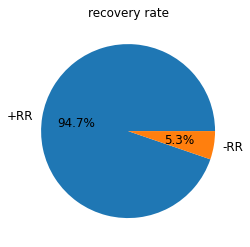

In [24]:
positive_RR_num = len(summarize_result[summarize_result.Recover_rate > 0])
negative_RR_num = len(summarize_result) - positive_RR_num + 1

RR_num = pd.Series({'+RR': positive_RR_num,
                      '-RR': negative_RR_num}, name= '')
print(RR_num)

RR_num.plot(kind='pie',
            figsize=(4, 4),
            fontsize=12,
            autopct='%1.1f%%' #'%.2f', '%1.1f%%'
           )
plt.title('recovery rate')

# Prediction Model

In [25]:
koos = output['KOOS']
data = pd.concat([symptoms.data_encode, pain.data_encode, ADL.data_encode, 
           Sport_Rec.data_encode, QOL.data_encode, koos], 
          axis=1)
data.index += 1 
data.head()

,ID,S1,S2,S3,S4,S5,S6,S7,P1,P2,...,SP1,SP2,SP3,SP4,SP5,Q1,Q2,Q3,Q4,KOOS
1,1.0,0,2,0,0,0,0,0,4,3.0,...,4.0,4,4,4,4,4,0.0,4,4,43.930
2,1.0,0,1,1,2,2,0,0,3,2.0,...,4.0,4,4,4,4,4,0.0,4,4,43.362
3,1.0,2,2,2,2,2,2,2,3,2.0,...,4.0,4,4,3,4,4,2.0,4,3,38.248
4,1.0,1,2,2,2,2,2,1,3,2.0,...,4.0,4,4,3,4,4,2.0,4,3,40.526
5,2.0,2,2,2,4,2,3,1,4,3.0,...,4.0,4,4,4,4,4,3.0,3,4,18.720


In [26]:
#!pip install openpyxl

In [27]:
infos = pd.read_excel('data/infos.xlsx')
infos = infos.dropna(how="all")
infos.columns = infos.columns.str.replace(' ', '')

print(infos.shape)
infos.head(3)

(75, 37)


,ID,Age,Gender,Chronicdesease,Knee,WBC,RBCs,HGB,HCT,MCV,...,KOOS2R,KOOS2L,KOOS3R,KOOS3L,HAKOOS4R,HAKOOS4L,6MKOOSR,6MKOOSL,12MKOOSR,12MKOOSL
0,1,46,female,Non,Left,5.41,4.8,10.66,33.9,38.1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2,55,female,HTN,Right,6.20,5.6,13.60,42.3,75.1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,3,55,female,HTN,Left,6.20,5.6,13.60,42.3,75.1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [28]:
infos.columns

Index(['ID', 'Age', 'Gender', 'Chronicdesease', 'Knee', 'WBC', 'RBCs', 'HGB',
       'HCT', 'MCV', 'MCH', 'MCHC', 'PLTs', 'Neutrophil%', 'Lymphocyte%',
       'Monocyte%', 'Eosinophil%', 'Basophil%', 'Neut(Abs)', 'Lymph(Abs)',
       'Monocyte(Abs)', 'Eosinophil(Abs)', 'Basophil(Abs)', 'KOOSPreR',
       'KOOSPreL', 'KOOS1R', 'KOOS1L', 'KOOS2R', 'KOOS2L', 'KOOS3R', 'KOOS3L',
       'HAKOOS4R', 'HAKOOS4L', '6MKOOSR', '6MKOOSL', '12MKOOSR', '12MKOOSL'],
      dtype='object')

In [29]:
cnames = infos.columns[:23]
infos_df = infos[cnames]
infos_df.index  += 1
infos_df.head()

,ID,Age,Gender,Chronicdesease,Knee,WBC,RBCs,HGB,HCT,MCV,...,Neutrophil%,Lymphocyte%,Monocyte%,Eosinophil%,Basophil%,Neut(Abs),Lymph(Abs),Monocyte(Abs),Eosinophil(Abs),Basophil(Abs)
1,1,46,female,Non,Left,5.41,4.80,10.66,33.9,38.1,...,58.47,35.24,3.12,1.96,0.94,3.17,1.91,0.17,0.11,0.05
2,2,55,female,HTN,Right,6.20,5.60,13.60,42.3,75.1,...,32.70,57.50,NaN,NaN,NaN,NaN,3.60,NaN,NaN,NaN
3,3,55,female,HTN,Left,6.20,5.60,13.60,42.3,75.1,...,32.70,57.50,NaN,NaN,NaN,NaN,3.60,NaN,NaN,NaN
4,4,43,male,Non,Left,4.20,3.45,13.50,30.0,72.6,...,43.50,48.50,NaN,NaN,NaN,1.90,2.00,NaN,NaN,NaN
5,5,65,female,Non,Right,7.80,6.15,11.20,35.4,57.5,...,71.40,21.80,NaN,NaN,NaN,5.60,1.70,NaN,NaN,NaN


In [30]:
#infos_df.dtypes

In [31]:
#infos_df['sex'] = infos_df.Gender.map({'male':1, 'female':0})

gender = pd.get_dummies(infos_df.Gender, drop_first=True).rename(columns=lambda x:'Gender')
knee = pd.get_dummies(infos_df.Knee, drop_first=True).rename(columns=lambda x:'Knee')
chronicdesease = pd.get_dummies(infos_df.Chronicdesease, drop_first=True, prefix='Chronicdesease')

infos_df.drop(['Gender', 'Chronicdesease', 'Knee'], axis=1, inplace=True) 
infos_df = pd.concat([infos_df, knee, gender, chronicdesease], axis=1)

In [32]:
infos_df

,ID,Age,WBC,RBCs,HGB,HCT,MCV,MCH,MCHC,PLTs,...,Lymph(Abs),Monocyte(Abs),Eosinophil(Abs),Basophil(Abs),Knee,Gender,Chronicdesease_DM + HTN,Chronicdesease_DM + HTN + ASTHMN,Chronicdesease_HTN,Chronicdesease_Non
1,1,46,5.41,4.80,10.66,33.9,38.1,26.1,31.4,210.3,...,1.91,0.17,0.11,0.05,0,0,0,0,0,1
2,2,55,6.20,5.60,13.60,42.3,75.1,24.2,32.2,150.0,...,3.60,NaN,NaN,NaN,1,0,0,0,1,0
3,3,55,6.20,5.60,13.60,42.3,75.1,24.2,32.2,150.0,...,3.60,NaN,NaN,NaN,0,0,0,0,1,0
4,4,43,4.20,3.45,13.50,30.0,72.6,29.0,32.0,204.0,...,2.00,NaN,NaN,NaN,0,1,0,0,0,1
5,5,65,7.80,6.15,11.20,35.4,57.5,18.3,31.8,424.0,...,1.70,NaN,NaN,NaN,1,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
71,71,69,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,0,0,0,0,0,1
72,72,51,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,1,1,0,0,0,0
73,73,51,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,0,1,0,0,0,0
74,74,61,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,1,1,0,0,1,0


In [33]:
infos_df.columns

Index(['ID', 'Age', 'WBC', 'RBCs', 'HGB', 'HCT', 'MCV', 'MCH', 'MCHC', 'PLTs',
       'Neutrophil%', 'Lymphocyte%', 'Monocyte%', 'Eosinophil%', 'Basophil%',
       'Neut(Abs)', 'Lymph(Abs)', 'Monocyte(Abs)', 'Eosinophil(Abs)',
       'Basophil(Abs)', 'Knee', 'Gender', 'Chronicdesease_DM + HTN ',
       'Chronicdesease_DM + HTN + ASTHMN', 'Chronicdesease_HTN ',
       'Chronicdesease_Non '],
      dtype='object')

In [34]:
ID_Female = [infos_df.ID[i] for i in range(1, len(infos_df)+1) if infos_df.Gender[i]==0]
ID_Male = [infos_df.ID[i] for i in range(1, len(infos_df)+1) if infos_df.Gender[i]==1]

In [35]:
dic_general = { 
    'WBC' :  (3.8, 10.0),
    'MCV' : (80.0, 98.0),  
    'MCH' : (27.0, 32.0), 
    'MCHC': (31.5, 34.5), 
    'PLTs': (150.0, 450.0),
    'Neutrophil%'    : (40.0, 75.0), 
    'Lymphocyte%'    : (20.0, 40.0), 
    'Monocyte%'      : (2.0, 10.0), 
    'Eosinophil%'    : (1.0, 6.0), 
    'Basophil%'      : (0.0, 1.0),
    'Neut(Abs)'      : (2.0, 7.0), 
    'Lymph(Abs)'     : (1.0, 3.0), 
    'Monocyte(Abs)'  : (0.2, 1.0), 
    'Eosinophil(Abs)': (0.1, 0.5),
    'Basophil(Abs)'  : (0.02, 0.1)  
}

dic_male_female = {
    'RBCs': [(4.5, 5.5), (3.8, 4.8)], # male, female 
    'HGB' : [(15.0, 17.0), (12.0, 14.0)], 
    'HCT' : [(45.0, 50.0), (36.0, 46.0)]
}

In [36]:
random.seed(42)

for key, val in dic_general.items():
    for i in infos_df.ID:
        if math.isnan(infos_df[key][i]):
            infos_df[key][i] = round(random.uniform(val[0], val[1]), 2)
            
for key, val in dic_male_female.items():
    for i in ID_Male:
        if math.isnan(infos_df[key][i]):
            infos_df[key][i] = round(random.uniform(val[0][0], val[0][1]), 2)
            
    for i in ID_Female:
        if math.isnan(infos_df[key][i]):
            infos_df[key][i] = round(random.uniform(val[1][0], val[1][1]), 2)
            
# WBC general
#for i in infos_df.ID:
#    if math.isnan(infos_df['WBC'][i]):
#        infos_df['WBC'][i] = round(random.uniform(3.8, 10.0), 2)

In [37]:
infos_df.head()

,ID,Age,WBC,RBCs,HGB,HCT,MCV,MCH,MCHC,PLTs,...,Lymph(Abs),Monocyte(Abs),Eosinophil(Abs),Basophil(Abs),Knee,Gender,Chronicdesease_DM + HTN,Chronicdesease_DM + HTN + ASTHMN,Chronicdesease_HTN,Chronicdesease_Non
1,1,46,5.41,4.80,10.66,33.9,38.1,26.1,31.4,210.3,...,1.91,0.17,0.11,0.05,0,0,0,0,0,1
2,2,55,6.20,5.60,13.60,42.3,75.1,24.2,32.2,150.0,...,3.60,0.73,0.37,0.02,1,0,0,0,1,0
3,3,55,6.20,5.60,13.60,42.3,75.1,24.2,32.2,150.0,...,3.60,0.46,0.50,0.07,0,0,0,0,1,0
4,4,43,4.20,3.45,13.50,30.0,72.6,29.0,32.0,204.0,...,2.00,0.45,0.34,0.03,0,1,0,0,0,1
5,5,65,7.80,6.15,11.20,35.4,57.5,18.3,31.8,424.0,...,1.70,0.88,0.48,0.06,1,0,0,0,0,1


### Dataset

In [38]:
data.tail()

,ID,S1,S2,S3,S4,S5,S6,S7,P1,P2,...,SP1,SP2,SP3,SP4,SP5,Q1,Q2,Q3,Q4,KOOS
296,74.0,0,3,2,0,2,2,2,2,2.0,...,3.0,3,2,1,2,2,1.0,1,1,66.330
297,75.0,0,3,0,0,1,2,0,4,2.0,...,3.0,3,3,1,3,4,3.0,3,4,53.254
298,75.0,0,2,0,0,1,1,0,3,2.0,...,3.0,2,2,1,3,3,3.0,3,3,62.612
299,75.0,0,4,0,0,1,0,0,2,1.0,...,3.0,3,3,2,3,2,0.0,2,2,64.992
300,75.0,0,3,1,0,0,2,0,0,0.0,...,3.0,0,2,2,2,2,2.0,2,2,75.276


In [39]:
index_model_1 = np.arange(1, len(data)+1, 4)
index_model_2 = np.arange(2, len(data)+1, 4)
index_model_3 = np.arange(3, len(data)+1, 4)
index_model_4 = np.arange(4, len(data)+1, 4)

print(len(index_model_4))

75


In [40]:
data_ = data.copy()
data_.drop(['ID'], inplace=True, axis=1)

info_ = infos_df.copy()
info_.drop(['ID'], inplace=True, axis=1)

data1 = data_.loc[index_model_1].reset_index(drop=True)
data1.rename(columns={'KOOS': '1st_KOOS'}, inplace=True)
data1.index += 1 

data2 = data_.loc[index_model_2].reset_index(drop=True)
data2.rename(columns={'KOOS': '2nd_KOOS'}, inplace=True)
data2.index += 1 

data3 = data_.loc[index_model_3].reset_index(drop=True)
data3.rename(columns={'KOOS': '3th_KOOS'}, inplace=True)
data3.index += 1

data4 = data_.loc[index_model_4].reset_index(drop=True)
data4.rename(columns={'KOOS': '4th_KOOS'}, inplace=True)
data4.index += 1

data1['RR'] = data2['2nd_KOOS'] - data1['1st_KOOS']

data2['1st_KOOS'] = data1['1st_KOOS']
data2['RR'] = data3['3th_KOOS'] - data2['2nd_KOOS']

data3['2nd_KOOS'] = data2['2nd_KOOS']
data3['1st_KOOS'] = data1['1st_KOOS']
data3['RR'] = data4['4th_KOOS'] - data3['3th_KOOS']

In [41]:
data3.head()

,S1,S2,S3,S4,S5,S6,S7,P1,P2,P3,...,SP4,SP5,Q1,Q2,Q3,Q4,3th_KOOS,2nd_KOOS,1st_KOOS,RR
1,2,2,2,2,2,2,2,3,2.0,2,...,3,4,4,2.0,4,3,38.248,43.362,43.930,2.278
2,4,2,2,4,2,3,3,3,3.0,3,...,4,4,3,3.0,2,4,22.348,22.734,18.720,17.448
3,4,4,3,4,2,3,3,2,3.0,2,...,4,4,4,2.0,3,4,25.708,25.708,24.114,15.472
4,0,3,0,0,0,1,1,2,1.0,1,...,3,2,4,4.0,4,2,59.014,58.022,64.316,6.556
5,0,2,1,0,0,0,0,0,0.0,0,...,0,1,0,1.0,1,1,85.122,80.228,72.114,4.244


In [42]:
#data.head(10)

## Model 

In [43]:
from sklearn.model_selection import train_test_split
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
from sklearn.model_selection import cross_val_score

from sklearn import metrics #, cross_validation

from sklearn.metrics import mean_squared_error, r2_score

from xgboost import plot_importance 
from xgboost import XGBRegressor

import matplotlib.pylab as plt
%matplotlib inline

from matplotlib.pylab import rcParams

from datetime import datetime

/usr/local/lib/python3.8/dist-packages/pkg_resources/__init__.py:116: PkgResourcesDeprecationWarning: 0.1.36ubuntu1 is an invalid version and will not be supported in a future release
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/pkg_resources/__init__.py:116: PkgResourcesDeprecationWarning: 0.23ubuntu1 is an invalid version and will not be supported in a future release
  warnings.warn(


### Model 1
Input:
- questionnaire data
- main information
- first KOOS
- recovery rate after the first questionnaire

output
- **recovery rate** or **next KOOS score**

In [44]:
final_data1 = pd.concat([data1, info_], axis=1)
print(final_data1.shape)

X = final_data1.copy()
y = X.pop('RR')

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

print('X_train: ', X_train.shape)
print('y_train: ', y_train.shape)
print('X_valid: ', X_val.shape)
print('y_valid: ', y_val.shape)

(75, 69)
X_train:  (60, 68)
y_train:  (60,)
X_valid:  (15, 68)
y_valid:  (15,)


In [45]:
params_ = {
    # general parameters
    'booster': ['gbtree', 'gblinear'],
    # booster parameter
    'n_estimators': [100, 1000, 2000],
    'learning_rate': [0.3, 0.1, 0.01, 0.2],
    'min_child_weight' : [1, 2, 3],
    'max_depth': [6, 8, 10, 12, 15],
    'gamma': [0, 1, 2, 3],
    'subsample': [1, 0.5, 0.8],
    'reg_lambda': [1, 2],
    'reg_alpha': [0],
    'scale_pos_weight': [1]
}

# 'objective': ['reg:linear', 'binary:logistic', 'multi:softmax', 'multi:softprob']
#'colsample_bytree': [1, 0.5, 0.8],
params = {
    'booster': ['gbtree', 'gblinear'],
    'n_estimators': [100, 500, 1000],
    'reg_lambda': [1, 2],
    'reg_alpha': [0],
}

In [ ]:
#  silent=0, nthread=5, seed=0, missing=None, random_state=0
#xgb_model = XGBRegressor(nthread=5, min_child_weight=1, scale_pos_weight=1, max_depth=8, 
#                         gamma=0, subsample=0.8, colsample_bytree=0.8, learning_rate=0.1, seed=27)

xgb_model = XGBRegressor(nthread=5, seed=27)

print(xgb_model)

grid_search = GridSearchCV(estimator=xgb_model, param_grid=params_, scoring='neg_mean_squared_error',
                          n_jobs=-1, cv=3)

random_seach = RandomizedSearchCV(estimator=xgb_model, param_distributions=params_, n_iter=3,
                                 scoring='neg_mean_squared_error', n_jobs=-1, cv=3, verbose=3)

start=datetime.now()

grid_search.fit(X_train, y_train)

print(datetime.now()-start)

In [48]:
#grid_search.best_estimator_
#grid_search.best_params_
#grid_search.best_score_

In [49]:
xgb_model.fit(X_train, y_train)
score = xgb_model.score(X_train, y_train)
#print(xgb_model)
print("Training score: ", score)

cv_score = cross_val_score(xgb_model, X_train, y_train, cv=3)
print("CV score: ", cv_score.mean())

ypred = xgb_model.predict(X_val)
mse = mean_squared_error(y_val, ypred)


print("MSE: ", mse)
print("MSE: ", mse*(1/2.0))
print("r2_score: ", r2_score(y_val, ypred))

Training score:  0.999901290565583
CV score:  -0.6254426751626607
MSE:  72.15159939576048
MSE:  36.07579969788024
r2_score:  -0.3164171113546199


<Figure size 3600x3600 with 0 Axes>

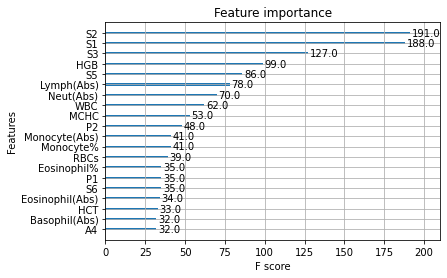

In [50]:
plt.figure(figsize=(50,50))
plot_importance(xgb_model, max_num_features=20)
plt.rcParams["figure.figsize"] = (6, 5)
plt.show()

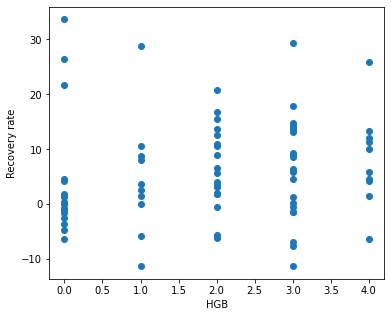

In [51]:
# find patern
plt.scatter(final_data1['S2'], final_data1['RR'])
plt.ylabel('Recovery rate')
plt.xlabel('HGB')
plt.show()

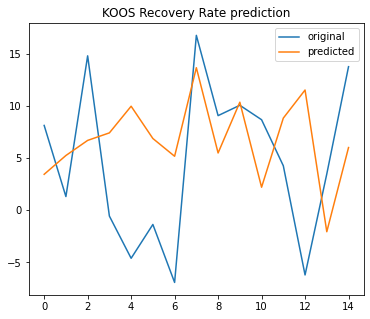

In [52]:
x_ax = range(len(y_val))
plt.plot(x_ax, y_val, label="original")
plt.plot(x_ax, ypred, label="predicted")
plt.title('KOOS Recovery Rate prediction')
plt.legend()
plt.show()